**User Segmention and Analysis**

Using the adopted criteria of at least 3 sessions wthin a week, we segment the set of all users into adopted, sporadic and low. Sporadic are users than meet the criteria of at least 3 sessions but not within the timeframe, while low have below three sessions in total.

Feature transformation and feature engineering is performed on a number of the features. *creation_source* is one hot encoded. This is not stricly neccessary for all models, but allows for flexiblity in model choice.  

inivited_by_user_id* is transformed to a binary feature that discriminates betwen invited and non-invated users. We investigated the hypothesis that multiple invites from particular users might lead to adoption, however number of user_id that were responsible for more than 1 invitation was miniminal across all user_segments. 

High cardinality features such as name and email address are dropped for analysis and model building. 

We engineered three additional features:  *n_visits*,*intersession_mu*,*usage_tenure*.  

*n_visits* is simply the total number of sessions for a given user_id. 

*intersession_mu* represents the the average duration in hours between sessions. user_id with 0 or 1 sessions were padded with 999 hours. Leaving these as NaN, would have resulted in a high number of non-adopted samples being dropped during model training.  

*usage_tenure* represents the number of days between creation_time and last_session_creation_time and reflects the approximate amount of time the user had been using the product.  We chose not to compute the difference between the current date and creation_time because the data is stale and does not reflect recent months. 

using data path: /Users/jonathan/Documents/Repos/asana/asana/data/
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_user_engagement.csv
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_users.csv
transforming features...
computing intervals between user sessions...
all columns successfully transformed
grouping on user ids...
filtering users that qualify based on total visits...
joining data...
scoring adoption based on visits per range of consecutive days...
segmenting users into adoption subsets...


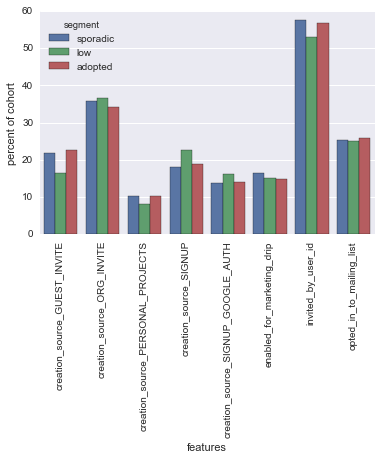

In [1]:
from asana.user_adoption.adoption_analyzer import AdoptionAnalyzer
%matplotlib inline

aa = AdoptionAnalyzer()
aa.transform_features()
segmented_users = aa.segment_engagement()
aa.visualize_segments(segmented_users)


**Summary of Exploratory Analysis**

Very little difference in the categorical features is observed between the three user segments: adopted, sporadic and low



**Adoption Predictor Training with all features**

The task specifically asks for feature importance in predicting user adoption. While many clasifiers are suitable for the task of predicting user adoption, a Random Forest classifier provides "out of the box" feature importance from the random feature subsetting during tree building and resulting out of bag error estimation across the ensemble of tress.


In [2]:
from asana.user_adoption.adoption_predictor import AdoptionPredictor

ap =  ap = AdoptionPredictor(training_iters=200)
ap.fit()

ap.best_model

using data path: /Users/jonathan/Documents/Repos/asana/asana/data/
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_user_engagement.csv
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_users.csv
transforming features...
computing intervals between user sessions...
all columns successfully transformed
grouping on user ids...
filtering users that qualify based on total visits...
joining data...
scoring adoption based on visits per range of consecutive days...
segmenting users into adoption subsets...
running random param search on RandomForestClassifier 


{'clf': RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
             criterion='entropy', max_depth=None, max_features='sqrt',
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'feature_importance': [('n_visits', 0.4163967370544876),
  ('intersession_mu', 0.34782357766208261),
  ('usage_tenure', 0.22199282931262226),
  ('opted_in_to_mailing_list', 0.0028524285395445555),
  ('enabled_for_marketing_drip', 0.0020812554074945873),
  ('creation_source_GUEST_INVITE', 0.0018123616649832245),
  ('creation_source_SIGNUP_GOOGLE_AUTH', 0.0016355018784954957),
  ('creation_source_ORG_INVITE', 0.0015895491179071413),
  ('creation_source_SIGNUP', 0.0013656659161483855),
  ('invited_by_user_id', 0.0013454388884323043),
  ('creation_source_PERSONAL_PROJECTS', 0.0011046545578016166)],
 'mean_

** Best Model and Feature Importance **

Given the minimal difference in the categorical features in discrminating the user segments, it is not suprising that they appear to be minimally important in predicting adoption.  The engineered features are time and visit based and are therefore closely related to the definition of adoption.  However, from an intervention perspective, the time between sessions and time the user has been using the product are potentially important signals. Users that have long durations between sessions are unlikely to adopt. Additionally, customers that are new the product should not trigger inteventions (e.g. email re-engagement campaings).  

The 3 most important features are **n_visits, usage_tensure and intersession_mu**. All other features appear marginally important.  The best model found from RandomSearchCV achieved an **f1 score 0.936**, suggesting strong precision and recall. To prevent the same users in train and set, LabelKFold was used to generate CV Train-Test splits. 

**Impact of Feature Pruning**

In [4]:
from asana.user_adoption.adoption_predictor import AdoptionPredictor

ap =  ap = AdoptionPredictor(training_iters=200)
ap.fit(drop_features=["n_visits","intersession_mu","usage_tenure"])
ap.best_model


using data path: /Users/jonathan/Documents/Repos/asana/asana/data/
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_user_engagement.csv
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_users.csv
transforming features...
computing intervals between user sessions...
all columns successfully transformed
grouping on user ids...
filtering users that qualify based on total visits...
joining data...
scoring adoption based on visits per range of consecutive days...
segmenting users into adoption subsets...
running random param search on RandomForestClassifier 


{'clf': RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
             criterion='gini', max_depth=3, max_features='log2',
             max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=26, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'feature_importance': [('creation_source_GUEST_INVITE', 0.47288007262706305),
  ('enabled_for_marketing_drip', 0.11759820507533363),
  ('opted_in_to_mailing_list', 0.10835512237946193),
  ('creation_source_PERSONAL_PROJECTS', 0.10171119627969949),
  ('creation_source_SIGNUP', 0.060711145377621234),
  ('invited_by_user_id', 0.058999813380705986),
  ('creation_source_SIGNUP_GOOGLE_AUTH', 0.049042979710296628),
  ('creation_source_ORG_INVITE', 0.030701465169818056)],
 'mean_score': 0.24545304897015713,
 'params': {'criterion': 'gini',
  'max_depth': 3,
  'max_features': 'log2',
  'min_samples_leaf': 2,
  'min_s

** Best Model and Feature Importance **

Excluding the 3 most relevant features from the previous round, we re-fit the model. The result is a poor classfier with an f1-score of ~0.25. 

** Impact of Subsets in Train/Test set **

In [5]:
from asana.user_adoption.adoption_predictor import AdoptionPredictor

ap =  ap = AdoptionPredictor(training_iters=200)
ap.fit(segments=["adopted","sporadic"])

ap.best_model

using data path: /Users/jonathan/Documents/Repos/asana/asana/data/
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_user_engagement.csv
loaded /Users/jonathan/Documents/Repos/asana/asana/data/takehome_users.csv
transforming features...
computing intervals between user sessions...
all columns successfully transformed
grouping on user ids...
filtering users that qualify based on total visits...
joining data...
scoring adoption based on visits per range of consecutive days...
segmenting users into adoption subsets...
running random param search on RandomForestClassifier 


{'clf': RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
             criterion='entropy', max_depth=None, max_features='sqrt',
             max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=9,
             min_weight_fraction_leaf=0.0, n_estimators=33, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'feature_importance': [('n_visits', 0.39567344883037064),
  ('intersession_mu', 0.33585284685471722),
  ('usage_tenure', 0.25742546096023083),
  ('opted_in_to_mailing_list', 0.00208964728563673),
  ('enabled_for_marketing_drip', 0.0016933971563717952),
  ('creation_source_GUEST_INVITE', 0.0014334460110123576),
  ('creation_source_ORG_INVITE', 0.0014119863048640789),
  ('creation_source_SIGNUP_GOOGLE_AUTH', 0.0011512244951799532),
  ('creation_source_PERSONAL_PROJECTS', 0.001143438626825373),
  ('creation_source_SIGNUP', 0.0010934103688045398),
  ('invited_by_user_id', 0.0010316931059863573)],
 'mean_sc

** Best Model and Feature Importance **

Including only the sporadic cohort while excluding the low cohort does not alter the most important features or the overall performance of the classifier. 

**Summary and Future Work**

Provide features showed little predictive power in terms of distinguishing between adopted and non-adopted users. The total number of visits, mean time in hours between sessions, and engagement tenure demonstrated to be most relevant for predicting adopted users. These enginered features are related to the defintion of adoption and may not provide sufficient means for intevention. However, the time between sessions could be monitored and used to trigger emails to re-engage users. When witheld, the ability to correctly classify adopted and non-adopted plumetted. 

The features provided primarily pertain to the source of users and when sessions occured. Data related to the sessions (e.g. user behviors and actions within the application are missing). Building an understanding of user cohorts and usage funnels within the product and relating that to the likelihood of becoming adopted could be a fruitful area for future work. 